In [1]:
import os
import librosa
import numpy as np
import soundfile
import IPython
import shutil
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
from imutils import paths
from tqdm import tqdm

from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import shutil
import subprocess

def download_and_extract_librispeech(destination_folder="/content"):

    librispeech_url = "http://openslr.elda.org/resources/12/dev-clean.tar.gz"
    librispeech_tar = os.path.join(destination_folder, "dev-clean.tar.gz")
    clean_speech_folder = os.path.join(destination_folder, "clean_speech")

    subprocess.run(["wget", librispeech_url, "-O", librispeech_tar])
    subprocess.run(["tar", "-xvf", librispeech_tar, "-C", destination_folder])

    os.makedirs(clean_speech_folder, exist_ok=True)

    for root, _, files in os.walk(os.path.join(destination_folder, "LibriSpeech/dev-clean")):
        for file in files:
            if file.endswith(".flac"):
                src = os.path.join(root, file)
                dest = os.path.join(clean_speech_folder, file)
                shutil.copy2(src, dest)

    shutil.rmtree(os.path.join(destination_folder, "LibriSpeech"))

    print(f"Clean speech files saved to {clean_speech_folder}")


def download_and_extract_esc50(destination_folder="/content"):

    esc50_url = "https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master"
    esc50_zip = os.path.join(destination_folder, "ESC-50-master.zip")
    noise_folder = os.path.join(destination_folder, "noise")

    subprocess.run(["wget", esc50_url, "-O", esc50_zip])
    subprocess.run(["unzip", esc50_zip, "-d", destination_folder])

    os.makedirs(noise_folder, exist_ok=True)

    for root, _, files in os.walk(os.path.join(destination_folder, "ESC-50-master/audio")):
        for file in files:
            if file.endswith(".wav"):
                src = os.path.join(root, file)
                dest = os.path.join(noise_folder, file)
                shutil.copy2(src, dest)

    shutil.rmtree(os.path.join(destination_folder, "ESC-50-master"))

    print(f"Noise files saved to {noise_folder}")

In [3]:
download_and_extract_librispeech()
download_and_extract_esc50()

Clean speech files saved to /content/clean_speech
Noise files saved to /content/noise


In [4]:
count_clean = 0
duration_clean = 0
duration_noise = 0
sample_rate=8000

for i in os.listdir('/content/clean_speech'):
  count_clean += 1
  y,sr = librosa.load(os.path.join('/content/clean_speech',i),sr=sample_rate)
  duration = librosa.get_duration(y=y,sr=sr)
  duration_clean+=duration

print(f'Number of clean audio files are {count_clean}')
print(f'Total duration of all clean audios {duration_clean//60}')

count_noise = 0
for i in os.listdir('/content/noise'):
  count_noise += 1
  y,sr = librosa.load(os.path.join('/content/noise',i),sr=sample_rate)
  duration = librosa.get_duration(y=y,sr=sr)
  duration_noise+=duration

print(f'Number of Noisy audio files are {count_noise}')
print(f'Total duration of all noise audios {duration_noise//60}')

Number of clean audio files are 2703
Total duration of all clean audios 323.0
Number of Noisy audio files are 2000
Total duration of all noise audios 166.0


In [ ]:
def audio_to_audio_frame_stack(sound_data, frame_length, hop_length_frame):
    sequence_sample_length = sound_data.shape[0]
    sound_data_list = [sound_data[start:start + frame_length] for start in range(
    0, sequence_sample_length - frame_length + 1, hop_length_frame)]
    sound_data_array = np.vstack(sound_data_list)
    return sound_data_array

In [ ]:
noise_dir="/content/noise/"
voice_dir="/content/clean_speech/"
path_save_spectrogram="/content/spectogram/"
sample_rate=8000
min_duration=5.0
frame_length=8064
hop_length_frame=8064
hop_length_frame_noise=5000
nb_samples=500
n_fft=255
hop_length_fft=63
dim_square_spec = int(n_fft / 2) + 1

In [7]:
clean_audio_files = os.listdir(voice_dir)
clean_random_audio = np.random.choice(clean_audio_files)
y,sr = librosa.load(os.path.join(voice_dir,clean_random_audio),sr=sample_rate)
clean = audio_to_audio_frame_stack(y,frame_length,hop_length_frame)
print("Clean Audio: {}".format(clean_random_audio))
print("Shape:{}".format(clean.shape))

Clean Audio: 174-50561-0011.flac
Shape:(9, 8064)


In [8]:
noisy_audio_files = os.listdir(noise_dir)
noisy_random_audio = np.random.choice(noisy_audio_files)
y,sr = librosa.load(os.path.join(noise_dir,noisy_random_audio),sr=sample_rate)
noise = audio_to_audio_frame_stack(y,frame_length,hop_length_frame)
print("Noise Audio: {}".format(noisy_random_audio))
print("Shape:{}".format(noise.shape))

Noise Audio: 5-219242-B-37.wav
Shape:(4, 8064)


In [9]:
clean = np.vstack(clean)
noise = np.vstack(noise)
print(clean)
print(noise)

[[ 1.44461181e-03  2.09097425e-03  1.95920747e-03 ...  1.43655520e-02
   9.08689573e-03  9.43639874e-03]
 [ 6.28152862e-03  1.11661851e-03  3.89762688e-04 ... -8.00210983e-04
  -5.53071499e-04 -7.29121268e-04]
 [-9.55794239e-05 -1.55835063e-03  7.00983219e-04 ... -2.33549401e-02
  -5.38188126e-03 -1.41218188e-03]
 ...
 [-5.56453690e-03  2.73390114e-03  8.56545195e-03 ... -8.10408965e-04
   1.17887976e-04 -1.09774992e-05]
 [ 2.65548006e-05  9.16924328e-05 -3.46008455e-04 ...  3.72530147e-03
  -2.20551994e-03  2.26903753e-03]
 [-2.37252237e-03 -1.26097165e-03  2.47230264e-03 ... -2.14688131e-04
  -2.81160726e-04 -3.18087172e-04]]
[[-2.5817379e-05  3.1973392e-04  1.0717245e-03 ...  3.9271486e-04
   1.7815932e-05  6.6970539e-04]
 [ 5.9435429e-04 -2.7899069e-04  5.2545493e-04 ...  1.9327116e-03
   1.3866607e-03  1.8147905e-03]
 [ 1.3951897e-03  1.4387905e-03  1.6797958e-03 ...  7.0897024e-04
   2.0568448e-04  2.6217900e-04]
 [ 7.5776957e-04  3.9106511e-04 -1.6899264e-04 ...  1.9251523e-03
 

In [ ]:
def blend_noise_randomly(voice, noise, nb_samples, frame_length):

    prod_voice = np.zeros((nb_samples, frame_length))
    prod_noise = np.zeros((nb_samples, frame_length))
    prod_noisy_voice = np.zeros((nb_samples, frame_length))

    for i in range(nb_samples):
        id_voice = np.random.randint(0, voice.shape[0])
        id_noise = np.random.randint(0, noise.shape[0])
        level_noise = np.random.uniform(0.2, 0.8)
        prod_voice[i, :] = voice[id_voice, :]
        prod_noise[i, :] = level_noise * noise[id_noise, :]
        prod_noisy_voice[i, :] = prod_voice[i, :] + prod_noise[i, :]

    return prod_voice, prod_noise, prod_noisy_voice

In [11]:
prod_voice, prod_noise, prod_noisy_voice = blend_noise_randomly(voice=clean,noise=noise,nb_samples=10,frame_length=frame_length)

In [12]:
prod_voice.shape

(10, 8064)

In [13]:
samples_clean = []
samples_noisy_clean = []
for x in prod_voice:
  samples_clean.extend(x)

for x in prod_noisy_voice:
  samples_noisy_clean.extend(x)

In [14]:
print(len(samples_clean))
print(len(samples_noisy_clean))

80640
80640


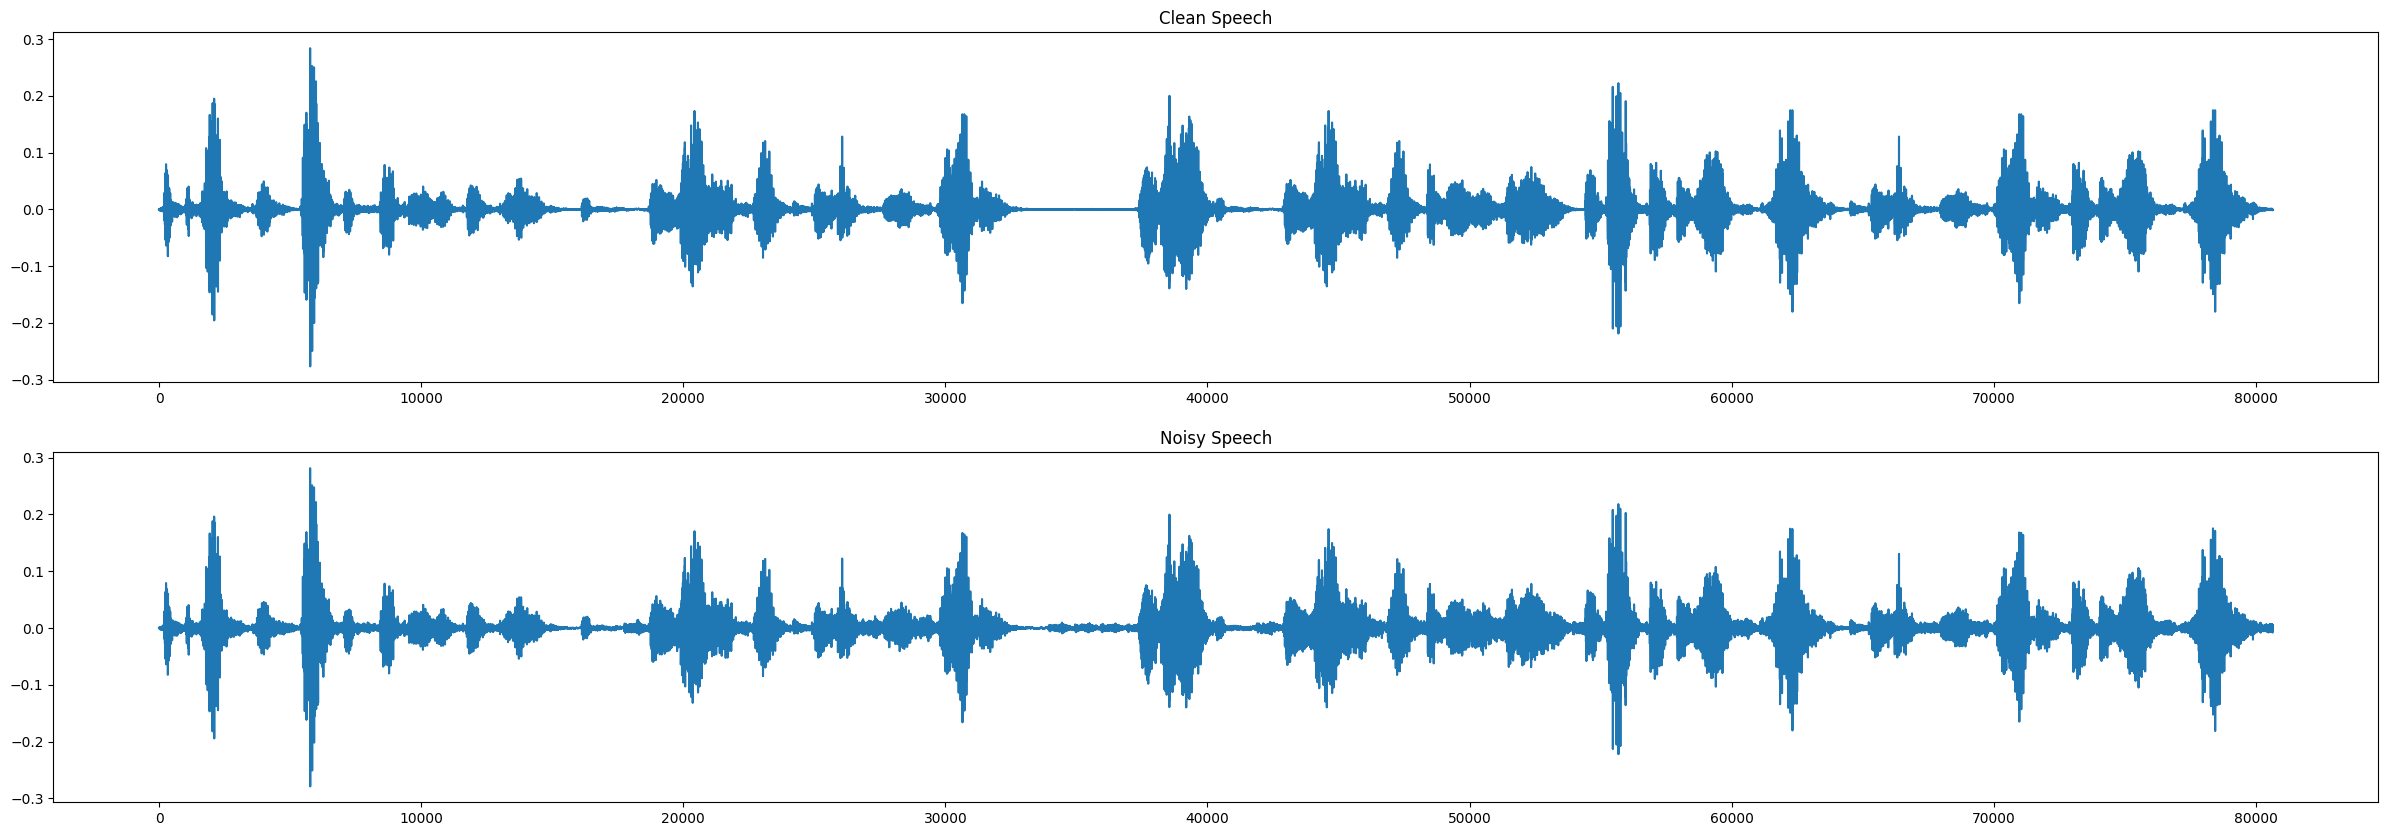

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.subplot(211)
plt.title("Clean Speech")
plt.plot(samples_clean)

plt.subplot(212)
plt.title("Noisy Speech")
plt.plot(samples_noisy_clean)

plt.show()

In [16]:
import soundfile as sf
clean_nb_samples = prod_voice.shape[0]
clean_long = prod_voice.reshape(1, 10 * frame_length)*10
sf.write("clean_long.wav", clean_long[0,:], 8000, 'PCM_24')

In [17]:
from IPython.display import Audio
Audio('clean_long.wav')

In [18]:
noise_nb_samples = prod_noisy_voice.shape[0]
noise_long = prod_noisy_voice.reshape(1, 10 * frame_length)*10
sf.write("noise_long.wav", noise_long[0,:], 8000, 'PCM_24')

In [19]:
from IPython.display import Audio
Audio('noise_long.wav')

In [ ]:
import os
import random
import numpy as np
import librosa

import torch
from torch.utils.data import Dataset, DataLoader

def list_audio_files(folder, exts=(".wav", ".flac")):
    return [os.path.join(folder, f)
            for f in os.listdir(folder)
            if f.lower().endswith(exts)]

def frame_audio(y, frame_length, hop_length):
    n_frames = 1 + (len(y) - frame_length) // hop_length
    return np.stack([
        y[i*hop_length : i*hop_length + frame_length]
        for i in range(n_frames)
    ], axis=0)

def compute_mag_spectrogram(frame, n_fft, hop_length):
    S = librosa.stft(frame, n_fft=n_fft, hop_length=hop_length, center=False)
    return np.abs(S)

def pad_to_multiple(spec: np.ndarray, mult=8) -> np.ndarray:
     F, T = spec.shape
     pad_F = (mult - (F % mult)) % mult
     pad_T = (mult - (T % mult)) % mult
     if pad_F or pad_T:
         spec = np.pad(
             spec,
             ((0, pad_F), (0, pad_T)),
             mode="reflect"
         )
     return spec

class AudioDenoiseDataset(Dataset):
    def __init__(self,
                 clean_folder,
                 noise_folder,
                 sample_rate=8000,
                 frame_length=8064,
                 hop_length_frame=8064,
                 n_fft=255,
                 hop_length_fft=63,
                 nb_samples=1000,
                 noise_levels=(0.2,0.8)):
        super().__init__()
        self.clean_files = list_audio_files(clean_folder)
        self.noise_files = list_audio_files(noise_folder)
        self.sr = sample_rate
        self.frame_len = frame_length
        self.hop_len_frame = hop_length_frame
        self.n_fft = n_fft
        self.hop_fft = hop_length_fft
        self.nb_samples = nb_samples
        self.noise_levels = noise_levels

    def __len__(self):
        return self.nb_samples

    def __getitem__(self, idx):
        clean_path = random.choice(self.clean_files)
        noise_path = random.choice(self.noise_files)

        clean_y, _ = librosa.load(clean_path, sr=self.sr)
        noise_y, _ = librosa.load(noise_path, sr=self.sr)

        clean_frames = frame_audio(clean_y, self.frame_len, self.hop_len_frame)
        noise_frames = frame_audio(noise_y, self.frame_len, self.hop_len_frame)

        c = clean_frames[np.random.randint(len(clean_frames))]
        n = noise_frames[np.random.randint(len(noise_frames))]

        level = np.random.uniform(*self.noise_levels)
        noisy = c + level * n

        spec_c = compute_mag_spectrogram(c, self.n_fft, self.hop_fft)
        spec_n = compute_mag_spectrogram(noisy, self.n_fft, self.hop_fft)

        def norm(x):
            x = np.log1p(x)
            x = x / np.max(np.abs(x))
            return x.astype(np.float32)
        spec_c = norm(spec_c)
        spec_n = norm(spec_n)

        def pad_to_multiple(spec, mult=8):
            F, T = spec.shape
            pad_F = (mult - (F % mult)) % mult
            pad_T = (mult - (T % mult)) % mult
            if pad_F or pad_T:
                spec = np.pad(spec,
                              ((0, pad_F), (0, pad_T)),
                              mode="reflect")
            return spec

        spec_c = pad_to_multiple(spec_c, mult=8)
        spec_n = pad_to_multiple(spec_n, mult=8)

        return (
            torch.from_numpy(spec_n)[None, ...],
            torch.from_numpy(spec_c)[None, ...],
            noisy.astype(np.float32),
            c.astype(np.float32),
        )


In [21]:
clean_dir = "/content/clean_speech"
noise_dir = "/content/noise"

dataset = AudioDenoiseDataset(
    clean_folder=clean_dir,
    noise_folder=noise_dir,
    sample_rate=8000,
    frame_length=8064,
    hop_length_frame=8000,
    n_fft=255,
    hop_length_fft=63,
    nb_samples=5000,
    noise_levels=(0.2, 0.8),
)
loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

noisy_batch, clean_batch, noisy_wave_batch, clean_wave_batch = next(iter(loader))
print("Noisy spectrogram batch:", noisy_batch.shape)
print("Clean spectrogram batch:", clean_batch.shape)

Noisy spectrogram batch: torch.Size([16, 1, 128, 128])
Clean spectrogram batch: torch.Size([16, 1, 128, 128])


In [22]:
noisy_spec, clean_spec, noisy_wave, clean_wave = next(iter(loader))

noisy_wav = noisy_wave[0].numpy()
clean_wav = clean_wave[0].numpy()

import soundfile as sf
sf.write("clean_sample.wav", clean_wav, 8000)
sf.write("noisy_sample.wav", noisy_wav, 8000)

from IPython.display import Audio, display
print("Clean sample:")
display(Audio("clean_sample.wav", rate=8000))
print("Noisy sample:")
display(Audio("noisy_sample.wav", rate=8000))


Clean sample:


Noisy sample:


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv   = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim,     kernel_size=1)
        self.gamma      = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch, C, H, W = x.size()
        proj_query = self.query_conv(x).view(batch, -1, H*W).permute(0, 2, 1)  
        proj_key   = self.key_conv(x).view(batch, -1, H*W)             
        energy     = torch.bmm(proj_query, proj_key)                  
        attention  = F.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch, -1, H*W)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch, C, H, W)
        return self.gamma * out + x


class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(
                nn.Sequential(
                    nn.BatchNorm2d(in_channels + i * growth_rate),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels + i * growth_rate, growth_rate, kernel_size=3, padding=1)
                )
            )

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            out = layer(torch.cat(features, 1))
            features.append(out)
        return torch.cat(features, 1)


class TFDenseUNetGenerator(nn.Module):
    def __init__(self, in_channels=1, base_channels=32, growth_rate=16, num_layers=4):
        super().__init__()
        self.enc1 = DenseBlock(in_channels, growth_rate, num_layers)
        enc1_out = in_channels + num_layers * growth_rate
        self.down1 = nn.Conv2d(enc1_out, base_channels, kernel_size=4, stride=2, padding=1)

        self.enc2 = DenseBlock(base_channels, growth_rate, num_layers)
        enc2_out = base_channels + num_layers * growth_rate
        self.down2 = nn.Conv2d(enc2_out, base_channels*2, kernel_size=4, stride=2, padding=1)

        self.enc3 = DenseBlock(base_channels*2, growth_rate, num_layers)
        enc3_out = base_channels*2 + num_layers * growth_rate
        self.down3 = nn.Conv2d(enc3_out, base_channels*4, kernel_size=4, stride=2, padding=1)

        self.bottleneck = DenseBlock(base_channels*4, growth_rate, num_layers)
        bottleneck_out = base_channels*4 + num_layers * growth_rate
        self.attn = SelfAttention(bottleneck_out)

        self.up3 = nn.ConvTranspose2d(bottleneck_out, base_channels*2, kernel_size=4, stride=2, padding=1)
        dec3_in = base_channels*2 + enc3_out
        self.dec3 = DenseBlock(dec3_in, growth_rate, num_layers)
        dec3_out = dec3_in + num_layers * growth_rate

        self.up2 = nn.ConvTranspose2d(dec3_out, base_channels, kernel_size=4, stride=2, padding=1)
        dec2_in = base_channels + enc2_out 
        self.dec2 = DenseBlock(dec2_in, growth_rate, num_layers)
        dec2_out = dec2_in + num_layers * growth_rate

        self.up1 = nn.ConvTranspose2d(dec2_out, base_channels, kernel_size=4, stride=2, padding=1)
        dec1_in = base_channels + enc1_out
        self.dec1 = DenseBlock(dec1_in, growth_rate, num_layers)
        dec1_out = dec1_in + num_layers * growth_rate

        self.final_conv = nn.Conv2d(dec1_out, in_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        d1 = self.down1(e1)

        e2 = self.enc2(d1)
        d2 = self.down2(e2)

        e3 = self.enc3(d2)
        d3 = self.down3(e3)

        b = self.bottleneck(d3)
        b = self.attn(b)

        u3 = self.up3(b)
        cat3 = torch.cat([u3, e3], dim=1)
        dec3 = self.dec3(cat3)

        u2 = self.up2(dec3)
        cat2 = torch.cat([u2, e2], dim=1)
        dec2 = self.dec2(cat2)

        u1 = self.up1(dec2)
        cat1 = torch.cat([u1, e1], dim=1)
        dec1 = self.dec1(cat1)

        out = self.final_conv(dec1)
        return out

class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=1, base_channels=64):
        super().__init__()
        layers = []
        layers.append(nn.Conv2d(in_channels, base_channels, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        ch = base_channels
        for i in range(1, 5):
            layers.append(nn.Conv2d(ch, ch*2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.InstanceNorm2d(ch*2))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            ch *= 2
        layers.append(nn.Conv2d(ch, 1, kernel_size=4, padding=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class MultiScaleDiscriminator(nn.Module):
    def __init__(self, num_scales=3):
        super().__init__()
        self.discriminators = nn.ModuleList([
            PatchGANDiscriminator() for _ in range(num_scales)
        ])
        self.downsample = nn.AvgPool2d(3, stride=2, padding=[1,1], count_include_pad=False)

    def forward(self, x):
        results = []
        for D in self.discriminators:
            results.append(D(x))
            x = self.downsample(x)
        return results

In [24]:
generator = TFDenseUNetGenerator()
discriminator = MultiScaleDiscriminator()
print(generator)
print(discriminator)

TFDenseUNetGenerator(
  (enc1): DenseBlock(
    (layers): ModuleList(
      (0): Sequential(
        (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Sequential(
        (0): BatchNorm2d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(17, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Sequential(
        (0): BatchNorm2d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(33, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Sequential(
        (0): BatchNorm2d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(49, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [25]:
!pip install pesq


  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp311-cp311-linux_x86_64.whl size=274947 sha256=e5c26f9f1f13f13866e5611956560502933aad89c7601c6d7123479c3117d470
  Stored in directory: /root/.cache/pip/wheels/ae/f1/23/2698d0bf31eec2b2aa50623b5d93b6206c49c7155d0e31345d
Successfully built pesq


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from pesq import pesq
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

def compute_inverse_mag_spectrogram(mag_spec, phase, n_fft, hop_length):
    stft_matrix = mag_spec * np.exp(1j * phase)
    return librosa.istft(stft_matrix, hop_length=hop_length, center=False)

def train(
    generator, discriminator,
    train_dataset, val_dataset,
    num_epochs=50, batch_size=16,
    lr=2e-4, device="cuda",
    save_dir="checkpoints"
):

    os.makedirs(save_dir, exist_ok=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

    g_opt = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    d_opt = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    l1_loss = nn.L1Loss().to(device)
    best_pesq = -np.inf
    history = {"train_mae": [], "train_psnr": [], "train_ssim": [], "val_pesq": []}

    for epoch in range(1, num_epochs+1):
        generator.train()
        discriminator.train()
        epoch_mae, epoch_psnr, epoch_ssim = 0.0, 0.0, 0.0
        prog = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")

        for noisy_spec, clean_spec, noisy_wav, clean_wav in prog:
            noisy_spec = noisy_spec.to(device)
            clean_spec = clean_spec.to(device)
            noisy_wav = noisy_wav.to(device)
            clean_wav = clean_wav.to(device)

            fake_clean = generator(noisy_spec)

            mae = l1_loss(fake_clean, clean_spec)

            g_opt.zero_grad()
            mae.backward()
            g_opt.step()

            fake_np = fake_clean.detach().cpu().numpy()[0,0]
            clean_np = clean_spec.detach().cpu().numpy()[0,0]
            epoch_mae += mae.item()
            epoch_psnr += psnr(clean_np, fake_np, data_range=fake_np.max()-fake_np.min())
            epoch_ssim += ssim(clean_np, fake_np, data_range=fake_np.max()-fake_np.min())

            prog.set_postfix({
                "MAE": epoch_mae / (prog.n+1),
                "PSNR": epoch_psnr / (prog.n+1),
                "SSIM": epoch_ssim / (prog.n+1)
            })

        history["train_mae"].append(epoch_mae / len(train_loader))
        history["train_psnr"].append(epoch_psnr / len(train_loader))
        history["train_ssim"].append(epoch_ssim / len(train_loader))


        generator.eval()
        val_pesq_total = 0.0
        valid_count = 0
        with torch.no_grad():
            for noisy_spec, clean_spec, noisy_wav, clean_wav in val_loader:

                noisy_spec = noisy_spec.to(device)
                denoised_spec = generator(noisy_spec).cpu().numpy()[0,0]

                frame_length = 8064
                n_fft = 255
                hop_length_fft = 63

                T_original = (frame_length - n_fft) // hop_length_fft + 1
                denoised_spec = denoised_spec[:, :T_original] 

                noisy_wav = noisy_wav.squeeze().numpy()
                clean_wav = clean_wav.squeeze().numpy()

                _, phase = librosa.magphase(librosa.stft(
                    noisy_wav,
                    n_fft=n_fft,
                    hop_length=hop_length_fft,
                    center=False
                ))

                denoised_wav = librosa.istft(
                    denoised_spec * phase,
                    hop_length=hop_length_fft,
                    center=False
                )

                min_len = min(len(clean_wav), len(denoised_wav))
                clean_wav = clean_wav[:min_len]
                denoised_wav = denoised_wav[:min_len]

                if min_len < 160:
                    continue

                if np.allclose(clean_wav, 0) or np.allclose(denoised_wav, 0):
                    continue

                clean_wav = clean_wav / np.max(np.abs(clean_wav))
                denoised_wav = denoised_wav / np.max(np.abs(denoised_wav))

                try:
                    p = pesq(8000, clean_wav, denoised_wav, 'nb')
                    val_pesq_total += p
                    valid_count += 1
                except:
                    print("PESQ computation failed for this sample")
                    continue

        val_pesq = val_pesq_total / valid_count if valid_count > 0 else 0
        history["val_pesq"].append(val_pesq)
        print(f"Epoch {epoch}: current PESQ = {val_pesq:.4f}, current best = {best_pesq:.4f}")
        if val_pesq > best_pesq:
            best_pesq = val_pesq
            print("Saved the best model")
            torch.save({
                "epoch": epoch,
                "generator_state": generator.state_dict(),
                "discriminator_state": discriminator.state_dict(),
                "optimizer_g": g_opt.state_dict(),
                "optimizer_d": d_opt.state_dict(),
                "best_pesq": best_pesq,
                "history": history
            }, os.path.join(save_dir, "best_model.pth"))
            with open(os.path.join(save_dir, "best_history.json"), "w") as f:
                json.dump(history, f, indent=2)

    epochs = range(1, num_epochs+1)
    plt.figure()
    plt.plot(epochs, history["train_mae"], label="Train MAE")
    plt.plot(epochs, history["train_psnr"], label="Train PSNR")
    plt.plot(epochs, history["train_ssim"], label="Train SSIM")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Training Metrics")
    plt.show()

    plt.figure()
    plt.plot(epochs, history["val_pesq"], label="Val PESQ")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Validation PESQ")
    plt.show()

    return history

# Training 5000 data 50 epochs 16 batch size

Epoch 1/50: 100%|██████████| 250/250 [01:04<00:00,  3.86it/s, MAE=0.0449, PSNR=25.6, SSIM=0.502]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 1: current PESQ = 1.5584, current best = -inf
Saved the best model


Epoch 2/50: 100%|██████████| 250/250 [01:01<00:00,  4.08it/s, MAE=0.0342, PSNR=25.6, SSIM=0.532]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 2: current PESQ = 1.5010, current best = 1.5584


Epoch 3/50: 100%|██████████| 250/250 [01:01<00:00,  4.06it/s, MAE=0.0302, PSNR=26.7, SSIM=0.589]


PESQ computation failed for this sample
Epoch 3: current PESQ = 1.5814, current best = 1.5584
Saved the best model


Epoch 4/50: 100%|██████████| 250/250 [01:00<00:00,  4.11it/s, MAE=0.0281, PSNR=27.4, SSIM=0.62]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 4: current PESQ = 1.5709, current best = 1.5814


Epoch 5/50: 100%|██████████| 250/250 [01:01<00:00,  4.07it/s, MAE=0.0269, PSNR=27.3, SSIM=0.624]


PESQ computation failed for this sample
Epoch 5: current PESQ = 1.6079, current best = 1.5814
Saved the best model


Epoch 6/50: 100%|██████████| 250/250 [01:02<00:00,  3.97it/s, MAE=0.0257, PSNR=27.6, SSIM=0.649]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 6: current PESQ = 1.6835, current best = 1.6079
Saved the best model


Epoch 7/50: 100%|██████████| 250/250 [01:00<00:00,  4.11it/s, MAE=0.0247, PSNR=28.1, SSIM=0.665]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 7: current PESQ = 1.6896, current best = 1.6835
Saved the best model


Epoch 8/50: 100%|██████████| 250/250 [01:01<00:00,  4.09it/s, MAE=0.023, PSNR=28.6, SSIM=0.705]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 8: current PESQ = 1.6739, current best = 1.6896


Epoch 9/50: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s, MAE=0.0226, PSNR=28.5, SSIM=0.69]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 9: current PESQ = 1.6559, current best = 1.6896


Epoch 10/50: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s, MAE=0.0224, PSNR=28.6, SSIM=0.712]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 10: current PESQ = 1.6440, current best = 1.6896


Epoch 11/50: 100%|██████████| 250/250 [01:00<00:00,  4.11it/s, MAE=0.0211, PSNR=28.9, SSIM=0.721]


PESQ computation failed for this sample
Epoch 11: current PESQ = 1.6943, current best = 1.6896
Saved the best model


Epoch 12/50: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s, MAE=0.0212, PSNR=29.4, SSIM=0.741]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 12: current PESQ = 1.6931, current best = 1.6943


Epoch 13/50: 100%|██████████| 250/250 [01:01<00:00,  4.09it/s, MAE=0.0205, PSNR=29.2, SSIM=0.724]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 13: current PESQ = 1.7213, current best = 1.6943
Saved the best model


Epoch 14/50: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s, MAE=0.0205, PSNR=29.1, SSIM=0.725]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 14: current PESQ = 1.6987, current best = 1.7213


Epoch 15/50: 100%|██████████| 250/250 [01:00<00:00,  4.10it/s, MAE=0.02, PSNR=29.4, SSIM=0.737]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 15: current PESQ = 1.7200, current best = 1.7213


Epoch 16/50: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s, MAE=0.0193, PSNR=30, SSIM=0.778]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 16: current PESQ = 1.6336, current best = 1.7213


Epoch 17/50: 100%|██████████| 250/250 [01:00<00:00,  4.10it/s, MAE=0.0195, PSNR=29.7, SSIM=0.751]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 17: current PESQ = 1.7380, current best = 1.7213
Saved the best model


Epoch 18/50: 100%|██████████| 250/250 [01:01<00:00,  4.07it/s, MAE=0.0186, PSNR=29.8, SSIM=0.769]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 18: current PESQ = 1.7623, current best = 1.7380
Saved the best model


Epoch 19/50: 100%|██████████| 250/250 [01:00<00:00,  4.11it/s, MAE=0.0183, PSNR=30.2, SSIM=0.767]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 19: current PESQ = 1.7289, current best = 1.7623


Epoch 20/50: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s, MAE=0.0179, PSNR=30.4, SSIM=0.796]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 20: current PESQ = 1.7850, current best = 1.7623
Saved the best model


Epoch 21/50: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s, MAE=0.0177, PSNR=30.4, SSIM=0.788]


PESQ computation failed for this sample
Epoch 21: current PESQ = 1.7368, current best = 1.7850


Epoch 22/50: 100%|██████████| 250/250 [01:01<00:00,  4.07it/s, MAE=0.0177, PSNR=30.4, SSIM=0.781]


PESQ computation failed for this sample
Epoch 22: current PESQ = 1.7698, current best = 1.7850


Epoch 23/50: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s, MAE=0.0176, PSNR=30.9, SSIM=0.798]


PESQ computation failed for this sample
Epoch 23: current PESQ = 1.7131, current best = 1.7850


Epoch 24/50: 100%|██████████| 250/250 [01:00<00:00,  4.10it/s, MAE=0.0173, PSNR=30.4, SSIM=0.793]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 24: current PESQ = 1.7467, current best = 1.7850


Epoch 25/50: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s, MAE=0.0168, PSNR=30.7, SSIM=0.804]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 25: current PESQ = 1.7565, current best = 1.7850


Epoch 26/50: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s, MAE=0.0169, PSNR=30.7, SSIM=0.797]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 26: current PESQ = 1.7294, current best = 1.7850


Epoch 27/50: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s, MAE=0.0165, PSNR=30.7, SSIM=0.793]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 27: current PESQ = 1.8057, current best = 1.7850
Saved the best model


Epoch 28/50: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s, MAE=0.0159, PSNR=31.6, SSIM=0.824]


PESQ computation failed for this sample
Epoch 28: current PESQ = 1.7119, current best = 1.8057


Epoch 29/50: 100%|██████████| 250/250 [01:01<00:00,  4.09it/s, MAE=0.016, PSNR=31.6, SSIM=0.814]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 29: current PESQ = 1.7393, current best = 1.8057


Epoch 30/50: 100%|██████████| 250/250 [01:00<00:00,  4.11it/s, MAE=0.0158, PSNR=31.3, SSIM=0.809]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 30: current PESQ = 1.7704, current best = 1.8057


Epoch 31/50: 100%|██████████| 250/250 [01:00<00:00,  4.10it/s, MAE=0.0156, PSNR=32, SSIM=0.825]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 31: current PESQ = 1.7176, current best = 1.8057


Epoch 32/50: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s, MAE=0.0154, PSNR=31.8, SSIM=0.827]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 32: current PESQ = 1.7499, current best = 1.8057


Epoch 33/50: 100%|██████████| 250/250 [01:01<00:00,  4.09it/s, MAE=0.0153, PSNR=31.5, SSIM=0.817]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 33: current PESQ = 1.7773, current best = 1.8057


Epoch 34/50: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s, MAE=0.0155, PSNR=31.9, SSIM=0.823]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 34: current PESQ = 1.7781, current best = 1.8057


Epoch 35/50: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s, MAE=0.0149, PSNR=31.3, SSIM=0.809]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 35: current PESQ = 1.7764, current best = 1.8057


Epoch 36/50: 100%|██████████| 250/250 [01:01<00:00,  4.08it/s, MAE=0.0151, PSNR=31.9, SSIM=0.824]


PESQ computation failed for this sample
Epoch 36: current PESQ = 1.7651, current best = 1.8057


Epoch 37/50: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s, MAE=0.0151, PSNR=32.1, SSIM=0.83]


PESQ computation failed for this sample
Epoch 37: current PESQ = 1.8112, current best = 1.8057
Saved the best model


Epoch 38/50: 100%|██████████| 250/250 [01:00<00:00,  4.10it/s, MAE=0.0147, PSNR=31.5, SSIM=0.823]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 38: current PESQ = 1.8019, current best = 1.8112


Epoch 39/50: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s, MAE=0.0147, PSNR=31.9, SSIM=0.824]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 39: current PESQ = 1.8062, current best = 1.8112


Epoch 40/50: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s, MAE=0.0143, PSNR=32.4, SSIM=0.846]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 40: current PESQ = 1.7772, current best = 1.8112


Epoch 41/50: 100%|██████████| 250/250 [01:00<00:00,  4.11it/s, MAE=0.0145, PSNR=31.3, SSIM=0.812]


PESQ computation failed for this sample
Epoch 41: current PESQ = 1.7524, current best = 1.8112


Epoch 42/50: 100%|██████████| 250/250 [01:00<00:00,  4.11it/s, MAE=0.0143, PSNR=31.7, SSIM=0.829]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 42: current PESQ = 1.8181, current best = 1.8112
Saved the best model


Epoch 43/50: 100%|██████████| 250/250 [01:01<00:00,  4.09it/s, MAE=0.0141, PSNR=32.6, SSIM=0.844]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 43: current PESQ = 1.7906, current best = 1.8181


Epoch 44/50: 100%|██████████| 250/250 [01:00<00:00,  4.11it/s, MAE=0.0143, PSNR=31.8, SSIM=0.825]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 44: current PESQ = 1.7576, current best = 1.8181


Epoch 45/50: 100%|██████████| 250/250 [01:00<00:00,  4.11it/s, MAE=0.0139, PSNR=33.4, SSIM=0.865]


PESQ computation failed for this sample
Epoch 45: current PESQ = 1.8130, current best = 1.8181


Epoch 46/50: 100%|██████████| 250/250 [01:00<00:00,  4.11it/s, MAE=0.014, PSNR=31.9, SSIM=0.828]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 46: current PESQ = 1.8261, current best = 1.8181
Saved the best model


Epoch 47/50: 100%|██████████| 250/250 [01:00<00:00,  4.11it/s, MAE=0.0136, PSNR=32.5, SSIM=0.846]


PESQ computation failed for this sample
Epoch 47: current PESQ = 1.8163, current best = 1.8261


Epoch 48/50: 100%|██████████| 250/250 [01:01<00:00,  4.09it/s, MAE=0.0136, PSNR=32.6, SSIM=0.838]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 48: current PESQ = 1.8113, current best = 1.8261


Epoch 49/50: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s, MAE=0.0135, PSNR=33, SSIM=0.855]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 49: current PESQ = 1.8082, current best = 1.8261


Epoch 50/50: 100%|██████████| 250/250 [01:00<00:00,  4.16it/s, MAE=0.0135, PSNR=32.3, SSIM=0.837]


PESQ computation failed for this sample
Epoch 50: current PESQ = 1.8130, current best = 1.8261


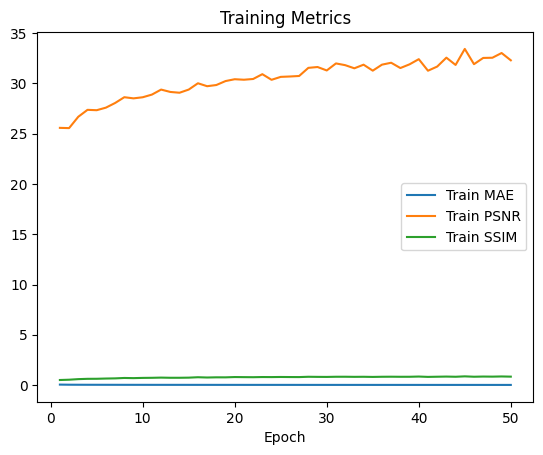

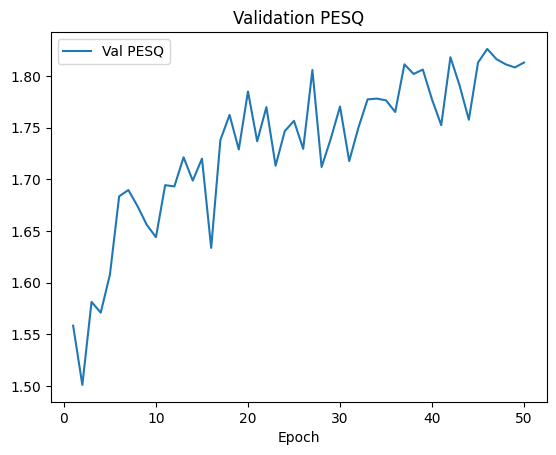

Training completed in 4820.88 seconds.


In [27]:
from torch.utils.data import Subset, DataLoader
import numpy as np
import time
full_dataset = AudioDenoiseDataset(
    clean_folder=clean_dir,
    noise_folder=noise_dir,
    sample_rate=8000,
    frame_length=8064,
    hop_length_frame=8000,
    n_fft=255,
    hop_length_fft=63,
    nb_samples=5000,
    noise_levels=(0.2, 0.8),
)


num_total = len(full_dataset)
indices = np.arange(num_total)
np.random.shuffle(indices)

train_ratio = 0.8
num_train = int(train_ratio * num_total)
train_idx, val_idx = indices[:num_train], indices[num_train:]


train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=1,  shuffle=False, num_workers=2)

generator = TFDenseUNetGenerator()
discriminator = MultiScaleDiscriminator()

device = "cuda" if torch.cuda.is_available() else "cpu"
generator.to(device)
discriminator.to(device)

start_time = time.time()

history = train(
    generator, discriminator,
    train_dataset, val_dataset,
    num_epochs=50, batch_size=16,
    lr=1e-4, device=device,
    save_dir="checkpoints"
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

# Model save to zip:


In [28]:
SAVE_ROOT = "/content/checkpoints"
print("Saved files:", os.listdir(SAVE_ROOT))
!zip -r /content/checkpoints.zip {SAVE_ROOT}
print("Zipped:", os.path.exists("/content/checkpoints.zip"))

Saved files: ['best_model.pth', 'best_history.json']
  adding: content/checkpoints/ (stored 0%)
  adding: content/checkpoints/best_model.pth (deflated 8%)
  adding: content/checkpoints/best_history.json (deflated 59%)
Zipped: True


# Results visualization

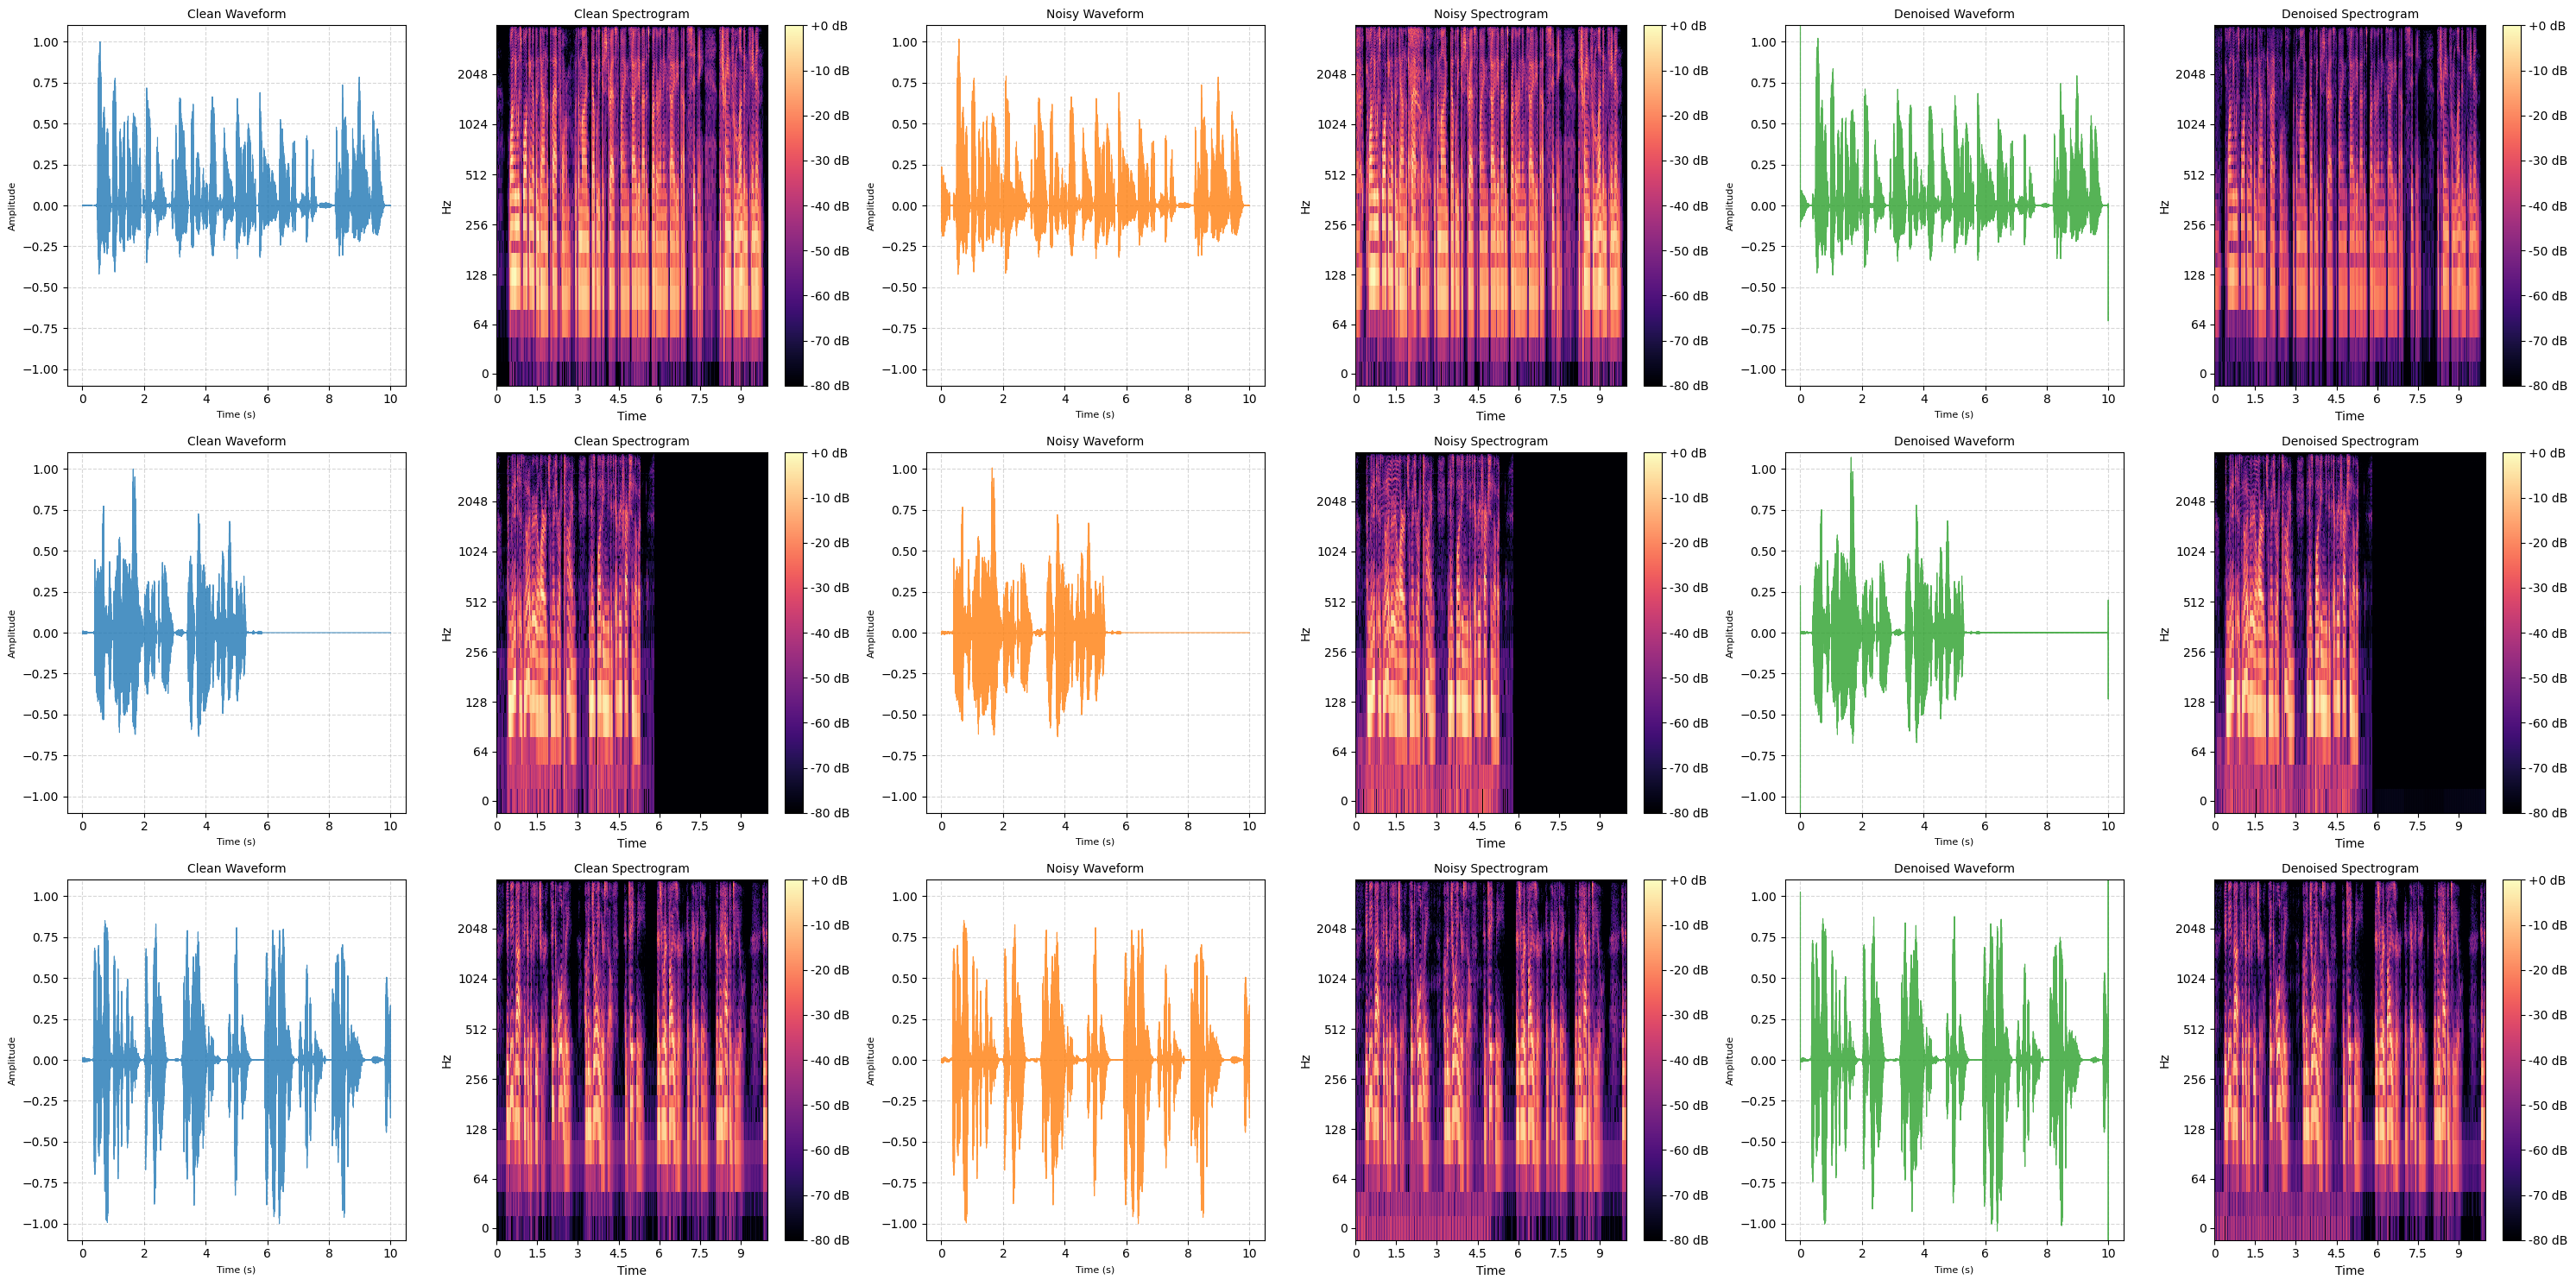


Sample 1 Results:
 PESQ Score: 3.76
=== Clean Audio ===


=== Noisy Audio ===


=== Denoised Audio ===



Sample 2 Results:
 PESQ Score: 3.49
=== Clean Audio ===


=== Noisy Audio ===


=== Denoised Audio ===



Sample 3 Results:
 PESQ Score: 3.88
=== Clean Audio ===


=== Noisy Audio ===


=== Denoised Audio ===


In [29]:
def visualize_denoising_sample(model, dataset, device, num_samples=3, duration=10):
    model.eval()
    sr = dataset.sr
    n_fft = dataset.n_fft
    hop_fft = dataset.hop_fft
    target_len = int(duration * sr)

    fig, axs = plt.subplots(num_samples, 6, figsize=(30, num_samples*5))

    results = []

    for i in range(num_samples):
        clean_path = random.choice(dataset.clean_files)
        noise_path = random.choice(dataset.noise_files)

        clean, _ = librosa.load(clean_path, sr=sr)
        clean = clean[:target_len] if len(clean) >= target_len else np.pad(clean, (0, target_len - len(clean)))

        noise, _ = librosa.load(noise_path, sr=sr)
        noise = noise[:target_len] if len(noise) >= target_len else np.pad(noise, (0, target_len - len(noise)))

        level = np.random.uniform(*dataset.noise_levels)
        noisy = clean + level * noise

        S_clean = librosa.stft(clean, n_fft=n_fft, hop_length=hop_fft, center=False)
        S_noisy = librosa.stft(noisy, n_fft=n_fft, hop_length=hop_fft, center=False)
        phase = np.angle(S_noisy)

        with torch.no_grad():
            mag_noisy = np.abs(S_noisy)
            log_mag = np.log1p(mag_noisy)
            max_val = np.max(np.abs(log_mag)) + 1e-9
            log_mag_norm = log_mag / max_val

            F, T = log_mag_norm.shape
            log_mag_padded = pad_to_multiple(log_mag_norm, mult=8)

            input_tensor = torch.from_numpy(log_mag_padded).unsqueeze(0).unsqueeze(0).float().to(device)

            output = model(input_tensor)

            denoised_log_norm = output.squeeze().cpu().numpy()
            denoised_log = denoised_log_norm * max_val
            mag_denoised = np.exp(denoised_log) - 1

            mag_denoised = mag_denoised[:F, :T]

        denoised_stft = mag_denoised * np.exp(1j * phase)
        denoised = librosa.istft(denoised_stft, hop_length=hop_fft, center=False)
        denoised = np.pad(denoised, (0, target_len - len(denoised)))[:target_len]

        try:
            pesq_score = pesq(sr, clean, denoised, 'nb')
        except Exception as e:
            pesq_score = None
            print(f"PESQ calculation failed for sample {i+1}: {str(e)}")

        results.append({
            'clean': clean,
            'noisy': noisy,
            'denoised': denoised,
            'pesq': pesq_score
        })

        time = np.linspace(0, duration, target_len)
        max_clean = np.max(np.abs(clean)) + 1e-9
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

        for j, (sig, title) in enumerate(zip(
            [clean, noisy, denoised],
            ["Clean", "Noisy", "Denoised"]
        )):
            ax = axs[i, j*2]
            ax.plot(time, sig/max_clean,
                   color=colors[j],
                   linewidth=0.8,
                   alpha=0.8)
            ax.set_ylim(-1.1, 1.1)
            ax.set_xlabel('Time (s)', fontsize=8)
            ax.set_ylabel('Amplitude', fontsize=8)
            ax.set_title(f"{title} Waveform", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.5)

            ax = axs[i, j*2+1]
            S = librosa.amplitude_to_db(np.abs(librosa.stft(sig, n_fft=n_fft)),
                                      ref=np.max)
            img = librosa.display.specshow(S,
                                         sr=sr,
                                         hop_length=hop_fft,
                                         x_axis='time',
                                         y_axis='log',
                                         ax=ax,
                                         cmap='magma')
            ax.set_title(f"{title} Spectrogram", fontsize=10)
            fig.colorbar(img, ax=ax, format='%+2.0f dB')

    plt.tight_layout()
    plt.savefig("100 000 data, 3 epochs 16 bs 1 GPU.png", dpi=300)
    plt.show()

    for idx, result in enumerate(results):
        max_audio = np.max(np.abs(result['clean']))
        print(f"\nSample {idx+1} Results:")
        if result['pesq'] is not None:
            print(f" PESQ Score: {result['pesq']:.2f}")

        for key in ['clean', 'noisy', 'denoised']:
            print(f"=== {key.capitalize()} Audio ===")
            display(Audio(result[key]/max_audio, rate=sr))


dataset = AudioDenoiseDataset(
    clean_folder=clean_dir,
    noise_folder=noise_dir,
    sample_rate=8000,
    frame_length=8064,
    hop_length_frame=8000,
    n_fft=255,
    hop_length_fft=63,
    nb_samples=50,
    noise_levels=(0.2, 0.8),
)

visualize_denoising_sample(generator, dataset, device, num_samples=3, duration=10)

# Hyperparameters check

# 5000 data 5 epochs batch size 8 lr 1e-4

Epoch 1/5: 100%|██████████| 500/500 [01:03<00:00,  7.93it/s, MAE=0.0417, PSNR=25.5, SSIM=0.497]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 1: current PESQ = 1.5439, current best = -inf
Saved the best model


Epoch 2/5: 100%|██████████| 500/500 [01:04<00:00,  7.72it/s, MAE=0.0312, PSNR=26.7, SSIM=0.592]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 2: current PESQ = 1.5550, current best = 1.5439
Saved the best model


Epoch 3/5: 100%|██████████| 500/500 [01:04<00:00,  7.73it/s, MAE=0.0281, PSNR=26.9, SSIM=0.627]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 3: current PESQ = 1.6479, current best = 1.5550
Saved the best model


Epoch 4/5: 100%|██████████| 500/500 [01:04<00:00,  7.73it/s, MAE=0.0258, PSNR=27.5, SSIM=0.662]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 4: current PESQ = 1.6222, current best = 1.6479


Epoch 5/5: 100%|██████████| 500/500 [01:04<00:00,  7.71it/s, MAE=0.0243, PSNR=27.9, SSIM=0.677]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 5: current PESQ = 1.6609, current best = 1.6479
Saved the best model


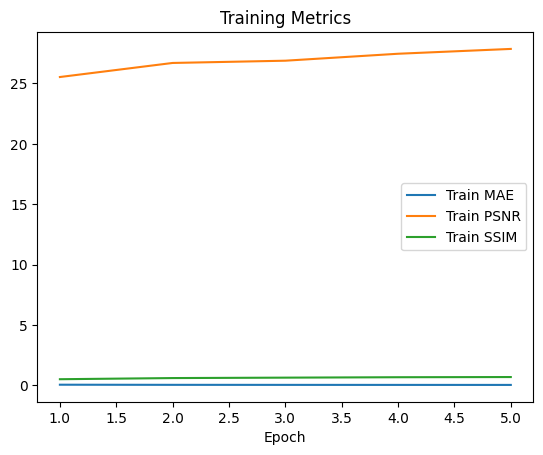

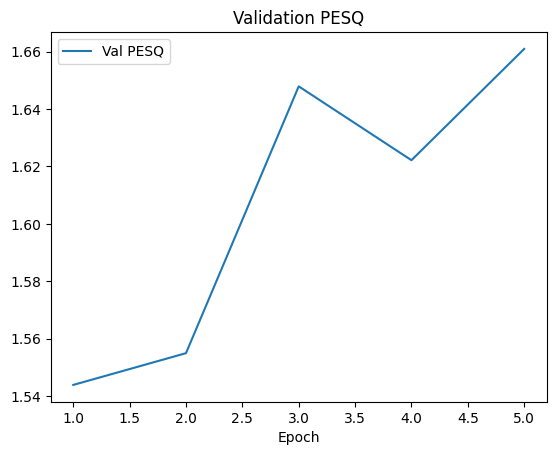

Training completed in 504.32 seconds.


In [30]:
from torch.utils.data import Subset, DataLoader
import numpy as np
import time
full_dataset = AudioDenoiseDataset(
    clean_folder=clean_dir,
    noise_folder=noise_dir,
    sample_rate=8000,
    frame_length=8064,
    hop_length_frame=8000,
    n_fft=255,
    hop_length_fft=63,
    nb_samples=5000,
    noise_levels=(0.2, 0.8),
)


num_total = len(full_dataset)
indices = np.arange(num_total)
np.random.shuffle(indices)

train_ratio = 0.8
num_train = int(train_ratio * num_total)
train_idx, val_idx = indices[:num_train], indices[num_train:]


train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=1,  shuffle=False, num_workers=2)

generator = TFDenseUNetGenerator()
discriminator = MultiScaleDiscriminator()

device = "cuda" if torch.cuda.is_available() else "cpu"
generator.to(device)
discriminator.to(device)

start_time = time.time()

history = train(
    generator, discriminator,
    train_dataset, val_dataset,
    num_epochs=5, batch_size=16,
    lr=1e-4, device=device,
    save_dir="checkpoints"
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

# 5000 data 5 epochs batch size 16 lr 1e-4

Epoch 1/5: 100%|██████████| 250/250 [00:58<00:00,  4.26it/s, MAE=0.0228, PSNR=28.1, SSIM=0.7]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 1: current PESQ = 1.6617, current best = -inf
Saved the best model


Epoch 2/5: 100%|██████████| 250/250 [00:59<00:00,  4.21it/s, MAE=0.0219, PSNR=28.8, SSIM=0.708]


PESQ computation failed for this sample
Epoch 2: current PESQ = 1.6880, current best = 1.6617
Saved the best model


Epoch 3/5: 100%|██████████| 250/250 [00:59<00:00,  4.23it/s, MAE=0.0209, PSNR=29, SSIM=0.725]


PESQ computation failed for this sample
Epoch 3: current PESQ = 1.6667, current best = 1.6880


Epoch 4/5: 100%|██████████| 250/250 [00:59<00:00,  4.22it/s, MAE=0.021, PSNR=28.5, SSIM=0.711]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 4: current PESQ = 1.6623, current best = 1.6880


Epoch 5/5: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s, MAE=0.0198, PSNR=29.5, SSIM=0.76]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 5: current PESQ = 1.6917, current best = 1.6880
Saved the best model


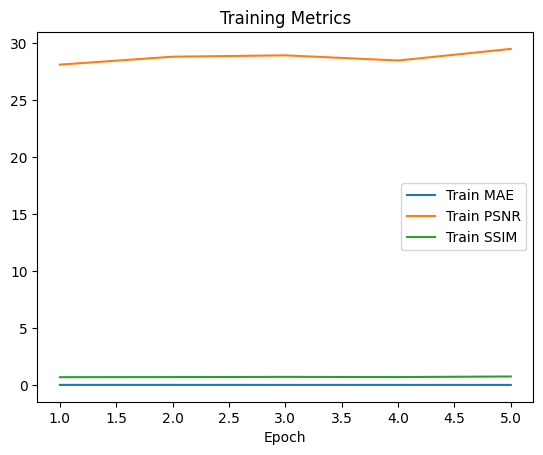

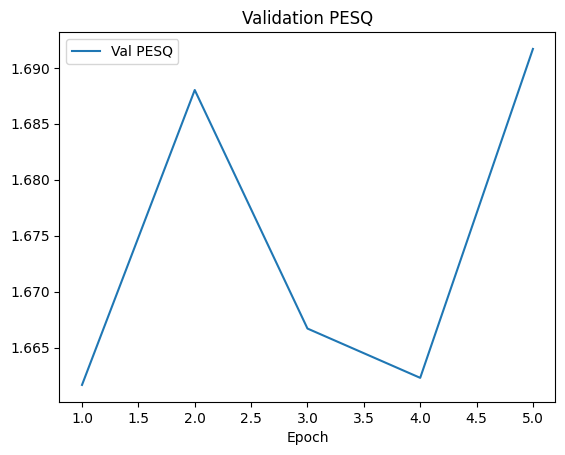

Training completed in 479.09 seconds.


In [31]:
start_time = time.time()

history = train(
    generator, discriminator,
    train_dataset, val_dataset,
    num_epochs=5, batch_size=16,
    lr=1e-4, device=device,
    save_dir="checkpoints"
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

# 5000 data 5 epochs batch size 32 lr 1e-4

Epoch 1/5: 100%|██████████| 125/125 [01:02<00:00,  2.00it/s, MAE=0.0464, PSNR=25.3, SSIM=0.498]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 1: current PESQ = 1.4870, current best = -inf
Saved the best model


Epoch 2/5: 100%|██████████| 125/125 [01:02<00:00,  1.99it/s, MAE=0.0375, PSNR=24.9, SSIM=0.53]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 2: current PESQ = 1.5101, current best = 1.4870
Saved the best model


Epoch 3/5: 100%|██████████| 125/125 [01:02<00:00,  2.01it/s, MAE=0.0335, PSNR=25.7, SSIM=0.55]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 3: current PESQ = 1.4692, current best = 1.5101


Epoch 4/5: 100%|██████████| 125/125 [01:02<00:00,  2.00it/s, MAE=0.0317, PSNR=26.3, SSIM=0.587]


Epoch 4: current PESQ = 1.6162, current best = 1.5101
Saved the best model


Epoch 5/5: 100%|██████████| 125/125 [01:03<00:00,  1.98it/s, MAE=0.0294, PSNR=26.8, SSIM=0.618]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 5: current PESQ = 1.5614, current best = 1.6162


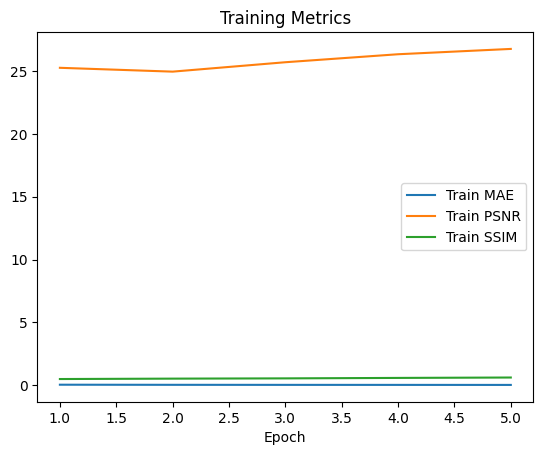

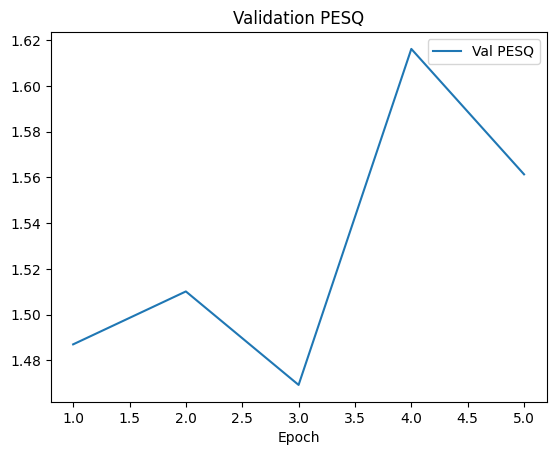

Training completed in 494.43 seconds.


In [32]:
generator = TFDenseUNetGenerator()
discriminator = MultiScaleDiscriminator()

device = "cuda" if torch.cuda.is_available() else "cpu"
generator.to(device)
discriminator.to(device)

start_time = time.time()

history = train(
    generator, discriminator,
    train_dataset, val_dataset,
    num_epochs=5, batch_size=32,
    lr=1e-4, device=device,
    save_dir="checkpoints"
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

# 5000 data 5 epochs batch size 8 lr 1e-3

Epoch 1/5: 100%|██████████| 500/500 [01:03<00:00,  7.91it/s, MAE=0.0472, PSNR=24.7, SSIM=0.511]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 1: current PESQ = 1.6164, current best = -inf
Saved the best model


Epoch 2/5: 100%|██████████| 500/500 [01:03<00:00,  7.89it/s, MAE=0.0242, PSNR=27.3, SSIM=0.699]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 2: current PESQ = 1.6272, current best = 1.6164
Saved the best model


Epoch 3/5: 100%|██████████| 500/500 [01:03<00:00,  7.82it/s, MAE=0.0218, PSNR=28, SSIM=0.735]


PESQ computation failed for this sample
Epoch 3: current PESQ = 1.6347, current best = 1.6272
Saved the best model


Epoch 4/5: 100%|██████████| 500/500 [01:03<00:00,  7.83it/s, MAE=126, PSNR=24.3, SSIM=0.341]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 4: current PESQ = 1.1842, current best = 1.6347


Epoch 5/5: 100%|██████████| 500/500 [01:07<00:00,  7.44it/s, MAE=0.322, PSNR=23.9, SSIM=0.27]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 5: current PESQ = 1.2479, current best = 1.6347


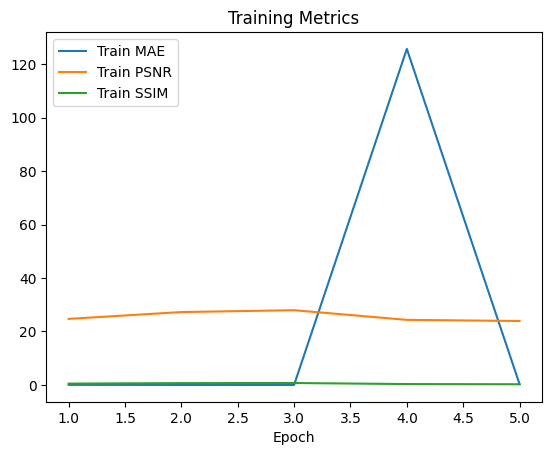

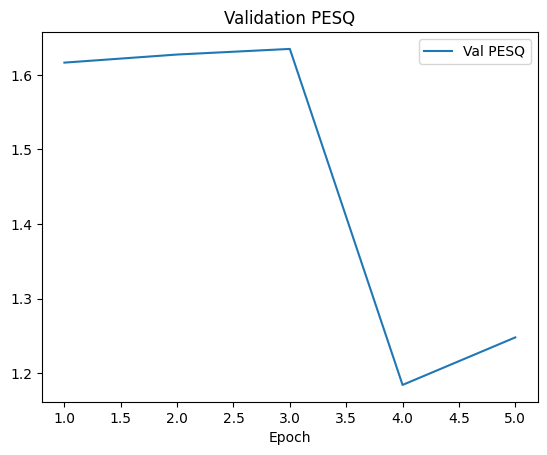

Training completed in 503.20 seconds.


In [33]:
generator = TFDenseUNetGenerator()
discriminator = MultiScaleDiscriminator()

device = "cuda" if torch.cuda.is_available() else "cpu"
generator.to(device)
discriminator.to(device)

start_time = time.time()

history = train(
    generator, discriminator,
    train_dataset, val_dataset,
    num_epochs=5, batch_size=8,
    lr=1e-3, device=device,
    save_dir="checkpoints"
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

# 5000 data 5 epochs batch size 8 lr 1e-2

Epoch 1/5: 100%|██████████| 500/500 [01:03<00:00,  7.93it/s, MAE=208, PSNR=21.6, SSIM=0.198]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 1: current PESQ = 1.3566, current best = -inf
Saved the best model


Epoch 2/5: 100%|██████████| 500/500 [01:02<00:00,  7.94it/s, MAE=0.369, PSNR=21.3, SSIM=0.165]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 2: current PESQ = 1.2420, current best = 1.3566


Epoch 3/5: 100%|██████████| 500/500 [01:03<00:00,  7.87it/s, MAE=0.195, PSNR=20.4, SSIM=0.151]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 3: current PESQ = 1.3739, current best = 1.3566
Saved the best model


Epoch 4/5: 100%|██████████| 500/500 [01:02<00:00,  7.94it/s, MAE=0.103, PSNR=19.8, SSIM=0.162]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 4: current PESQ = 1.4229, current best = 1.3739
Saved the best model


Epoch 5/5: 100%|██████████| 500/500 [01:02<00:00,  8.01it/s, MAE=0.204, PSNR=20.3, SSIM=0.221]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 5: current PESQ = 1.4689, current best = 1.4229
Saved the best model


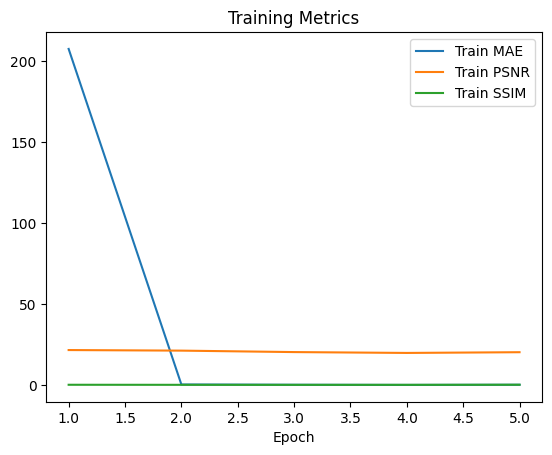

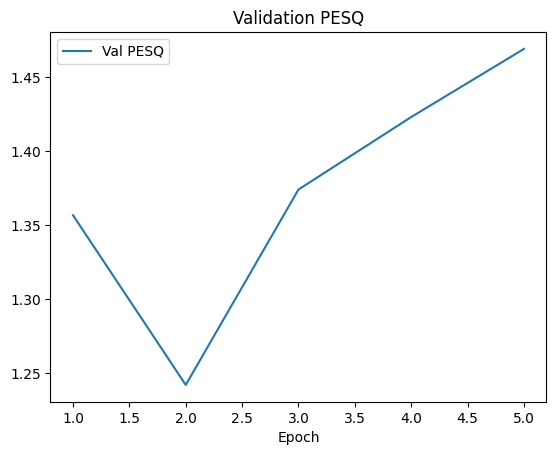

Training completed in 497.81 seconds.


In [34]:
generator = TFDenseUNetGenerator()
discriminator = MultiScaleDiscriminator()

device = "cuda" if torch.cuda.is_available() else "cpu"
generator.to(device)
discriminator.to(device)

start_time = time.time()

history = train(
    generator, discriminator,
    train_dataset, val_dataset,
    num_epochs=5, batch_size=8,
    lr=1e-2, device=device,
    save_dir="checkpoints"
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

# 5000 data 5 epochs batch size 16 lr 1e-3

Epoch 1/5: 100%|██████████| 250/250 [00:59<00:00,  4.23it/s, MAE=0.0585, PSNR=23.6, SSIM=0.473]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 1: current PESQ = 1.5456, current best = -inf
Saved the best model


Epoch 2/5: 100%|██████████| 250/250 [00:59<00:00,  4.23it/s, MAE=0.0298, PSNR=25.6, SSIM=0.616]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 2: current PESQ = 1.6496, current best = 1.5456
Saved the best model


Epoch 3/5: 100%|██████████| 250/250 [00:59<00:00,  4.21it/s, MAE=0.0231, PSNR=28, SSIM=0.727]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 3: current PESQ = 1.6579, current best = 1.6496
Saved the best model


Epoch 4/5: 100%|██████████| 250/250 [01:00<00:00,  4.16it/s, MAE=0.0212, PSNR=28.6, SSIM=0.749]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 4: current PESQ = 1.6786, current best = 1.6579
Saved the best model


Epoch 5/5: 100%|██████████| 250/250 [00:59<00:00,  4.21it/s, MAE=0.02, PSNR=28.9, SSIM=0.761]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 5: current PESQ = 1.6896, current best = 1.6786
Saved the best model


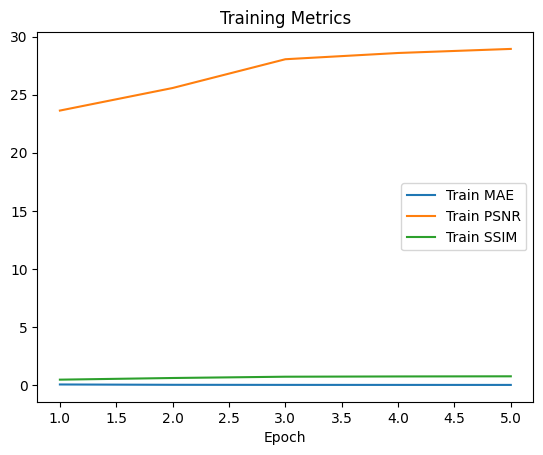

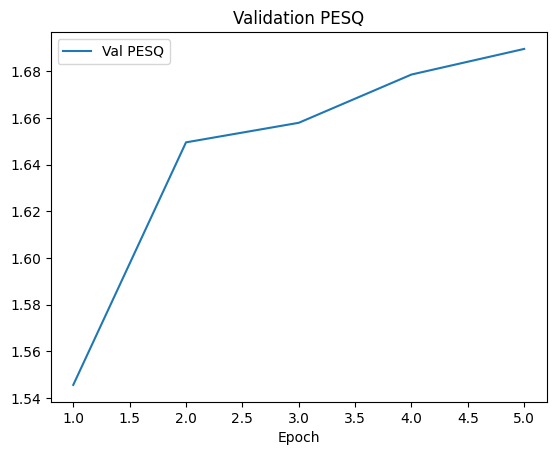

Training completed in 482.91 seconds.


In [35]:
generator = TFDenseUNetGenerator()
discriminator = MultiScaleDiscriminator()

device = "cuda" if torch.cuda.is_available() else "cpu"
generator.to(device)
discriminator.to(device)

start_time = time.time()

history = train(
    generator, discriminator,
    train_dataset, val_dataset,
    num_epochs=5, batch_size=16,
    lr=1e-3, device=device,
    save_dir="checkpoints"
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

# 5000 data 5 epochs batch size 16 lr 1e-2


Epoch 1/5: 100%|██████████| 250/250 [00:59<00:00,  4.20it/s, MAE=1.74e+3, PSNR=15.2, SSIM=0.0245]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 1: current PESQ = 1.2518, current best = -inf
Saved the best model


Epoch 2/5: 100%|██████████| 250/250 [00:59<00:00,  4.20it/s, MAE=1.39, PSNR=17.8, SSIM=0.0399]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 2: current PESQ = 1.2349, current best = 1.2518


Epoch 3/5: 100%|██████████| 250/250 [00:59<00:00,  4.22it/s, MAE=0.949, PSNR=17.6, SSIM=0.0446]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 3: current PESQ = 1.2547, current best = 1.2518
Saved the best model


Epoch 4/5: 100%|██████████| 250/250 [00:59<00:00,  4.18it/s, MAE=11.7, PSNR=19.9, SSIM=0.0914]


Epoch 4: current PESQ = 1.3036, current best = 1.2547
Saved the best model


Epoch 5/5: 100%|██████████| 250/250 [00:59<00:00,  4.23it/s, MAE=0.316, PSNR=20.8, SSIM=0.126]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 5: current PESQ = 1.2546, current best = 1.3036


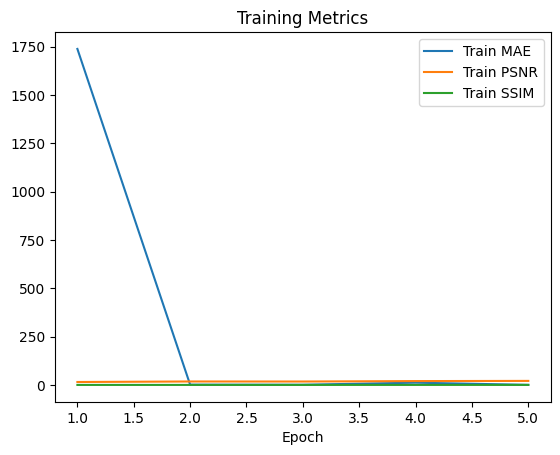

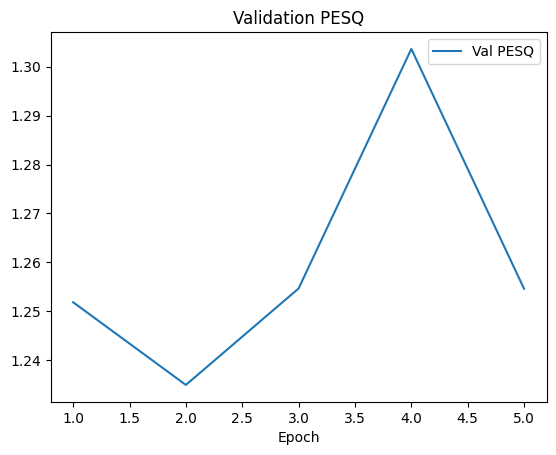

Training completed in 481.29 seconds.


In [36]:
generator = TFDenseUNetGenerator()
discriminator = MultiScaleDiscriminator()

device = "cuda" if torch.cuda.is_available() else "cpu"
generator.to(device)
discriminator.to(device)

start_time = time.time()

history = train(
    generator, discriminator,
    train_dataset, val_dataset,
    num_epochs=5, batch_size=16,
    lr=1e-2, device=device,
    save_dir="checkpoints"
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

# 5000 data 5 epochs batch size 32 lr 1e-3


Epoch 1/5: 100%|██████████| 125/125 [01:03<00:00,  1.98it/s, MAE=0.078, PSNR=23.1, SSIM=0.377]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 1: current PESQ = 1.4473, current best = -inf
Saved the best model


Epoch 2/5: 100%|██████████| 125/125 [01:02<00:00,  2.01it/s, MAE=0.0352, PSNR=24.2, SSIM=0.521]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 2: current PESQ = 1.4545, current best = 1.4473
Saved the best model


Epoch 3/5: 100%|██████████| 125/125 [01:02<00:00,  2.00it/s, MAE=0.0294, PSNR=26.1, SSIM=0.617]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 3: current PESQ = 1.5624, current best = 1.4545
Saved the best model


Epoch 4/5: 100%|██████████| 125/125 [01:02<00:00,  2.00it/s, MAE=0.0256, PSNR=27.1, SSIM=0.664]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 4: current PESQ = 1.6549, current best = 1.5624
Saved the best model


Epoch 5/5: 100%|██████████| 125/125 [01:02<00:00,  1.99it/s, MAE=0.0226, PSNR=28, SSIM=0.71]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 5: current PESQ = 1.6723, current best = 1.6549
Saved the best model


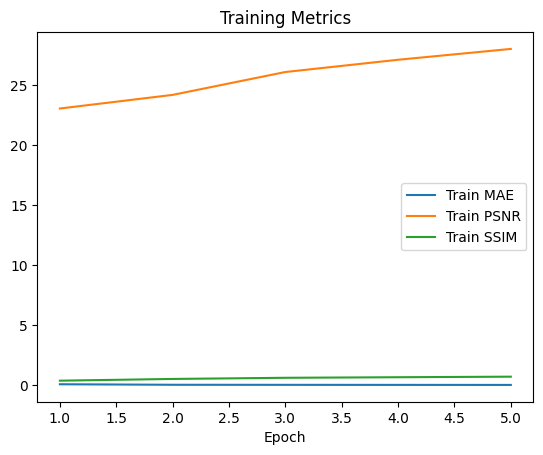

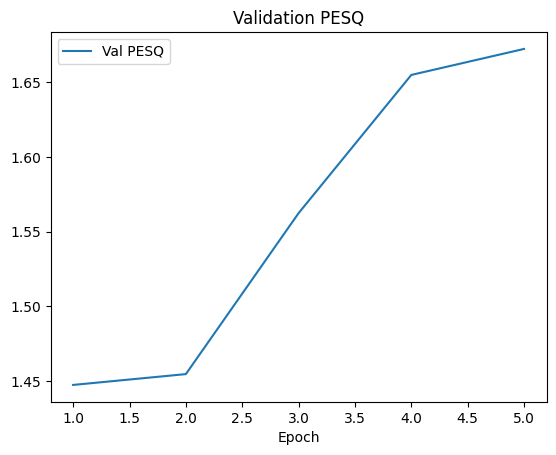

Training completed in 497.04 seconds.


In [37]:
generator = TFDenseUNetGenerator()
discriminator = MultiScaleDiscriminator()

device = "cuda" if torch.cuda.is_available() else "cpu"
generator.to(device)
discriminator.to(device)

start_time = time.time()

history = train(
    generator, discriminator,
    train_dataset, val_dataset,
    num_epochs=5, batch_size=32,
    lr=1e-3, device=device,
    save_dir="checkpoints"
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

# 5000 data 5 epochs batch size 32 lr 1e-2


Epoch 1/5: 100%|██████████| 125/125 [01:02<00:00,  2.01it/s, MAE=211, PSNR=18.9, SSIM=0.0817]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 1: current PESQ = 1.2672, current best = -inf
Saved the best model


Epoch 2/5: 100%|██████████| 125/125 [01:02<00:00,  2.01it/s, MAE=0.244, PSNR=21, SSIM=0.165]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 2: current PESQ = 1.3802, current best = 1.2672
Saved the best model


Epoch 3/5: 100%|██████████| 125/125 [01:02<00:00,  2.00it/s, MAE=0.146, PSNR=21, SSIM=0.187]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 3: current PESQ = 1.2571, current best = 1.3802


Epoch 4/5: 100%|██████████| 125/125 [01:02<00:00,  2.00it/s, MAE=0.155, PSNR=21.6, SSIM=0.263]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 4: current PESQ = 1.3394, current best = 1.3802


Epoch 5/5: 100%|██████████| 125/125 [01:02<00:00,  2.01it/s, MAE=0.109, PSNR=22.3, SSIM=0.294]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 5: current PESQ = 1.4269, current best = 1.3802
Saved the best model


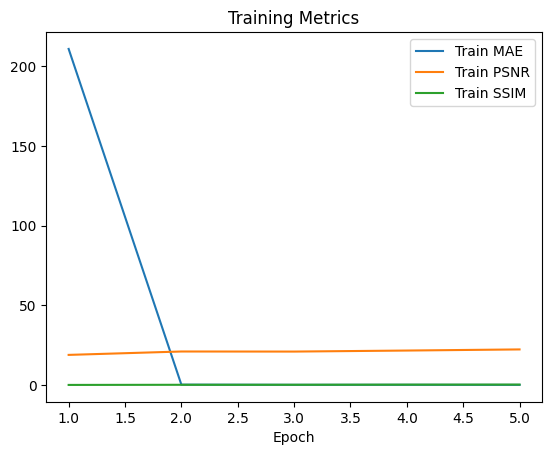

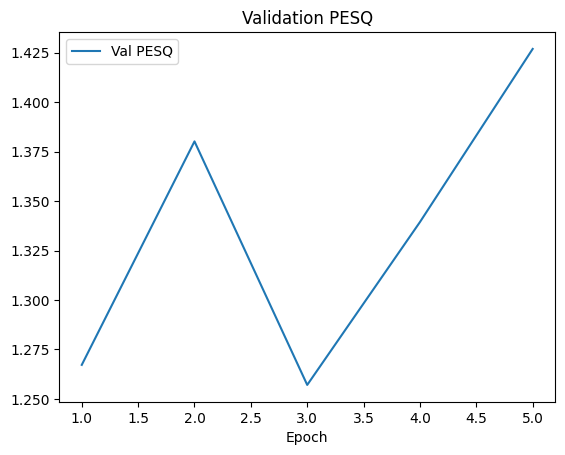

Training completed in 496.41 seconds.


In [38]:
generator = TFDenseUNetGenerator()
discriminator = MultiScaleDiscriminator()

device = "cuda" if torch.cuda.is_available() else "cpu"
generator.to(device)
discriminator.to(device)

start_time = time.time()

history = train(
    generator, discriminator,
    train_dataset, val_dataset,
    num_epochs=5, batch_size=32,
    lr=1e-2, device=device,
    save_dir="checkpoints"
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")

Epoch 1/5: 100%|██████████| 63/63 [01:03<00:00,  1.01s/it, MAE=0.0513, PSNR=24.9, SSIM=0.526]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 1: current PESQ = 1.4923, current best = -inf
Saved the best model


Epoch 2/5: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, MAE=0.0399, PSNR=25.9, SSIM=0.557]


PESQ computation failed for this sample
Epoch 2: current PESQ = 1.5096, current best = 1.4923
Saved the best model


Epoch 3/5: 100%|██████████| 63/63 [01:02<00:00,  1.01it/s, MAE=0.0362, PSNR=25.5, SSIM=0.587]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 3: current PESQ = 1.5735, current best = 1.5096
Saved the best model


Epoch 4/5: 100%|██████████| 63/63 [01:03<00:00,  1.00s/it, MAE=0.0342, PSNR=25.1, SSIM=0.567]


PESQ computation failed for this sample
PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 4: current PESQ = 1.5402, current best = 1.5735


Epoch 5/5: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it, MAE=0.0319, PSNR=26.3, SSIM=0.626]


PESQ computation failed for this sample
PESQ computation failed for this sample
Epoch 5: current PESQ = 1.5414, current best = 1.5735


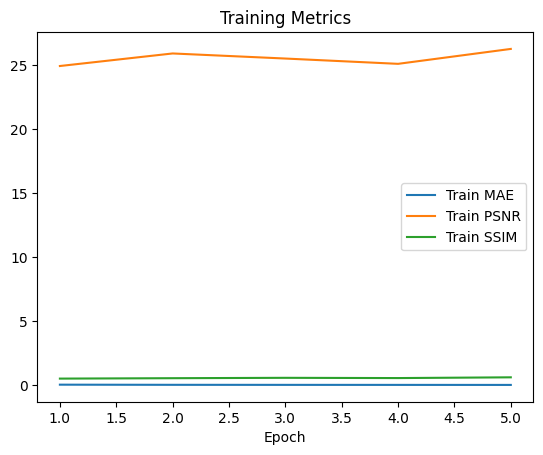

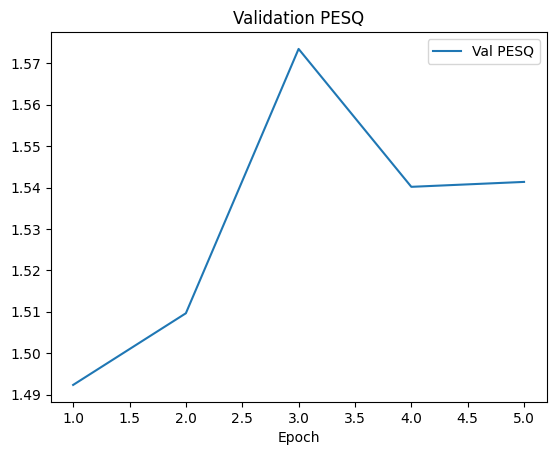

Training completed in 500.25 seconds.


In [40]:
generator = TFDenseUNetGenerator()
discriminator = MultiScaleDiscriminator()

device = "cuda" if torch.cuda.is_available() else "cpu"
generator.to(device)
discriminator.to(device)

start_time = time.time()

history = train(
    generator, discriminator,
    train_dataset, val_dataset,
    num_epochs=5, batch_size=64,
    lr=1e-4, device=device,
    save_dir="checkpoints"
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training completed in {elapsed_time:.2f} seconds.")